# Welcome to the Macrosystems Blog!

We're here to get you up-to-speed on the progress we've made so far on our project titled "Drivers of Hyperspectral Variation at NEON Sites in the Western United States". 

Generally, we'll be discussing:

1. Why our topic is important
2. The work that has been done in the subject area prior to our project
3. What our methods are
4. Our current findings and conclusions

Let's get started!

### Project Importance
	
Our project is the beginning of a large endeavor that will ultimately identify plants on the ground at NEON sites using remote sensing data. This could greatly improve the ways in which vegetation surveys are conducted and plant communities are monitored. More specifically, the outcome of the larger project could be applied to make vegetation surveys more efficient and accurate, track non-native plant species, examine plant migration as a result of climate change, or monitor rare plant abundances.

### Previous Work Prior to this Project

In fact, using remote sensing to identify plants for the purposes above is actively being explored.

1. [Multispectral Approach for Identifying Invasive Plant Species Based on Flowering Phenology Characteristics](https://www.mdpi.com/2072-4292/11/8/953/htm)
2. [No place to hide: Rare plant detection through remote sensing](https://onlinelibrary.wiley.com/doi/full/10.1111/ddi.13244) 

While identifying plants using remote sensing is being researched, there are great [advantages to conducting this type of work at long-term ecological monitoring sites](https://www.sciencedirect.com/science/article/pii/S0048969717321095#:~:text=Long%2Dterm%20ecological%20research%20can,trends%20(M%C3%BCller%20et%20al.%2C) such as NEON. For example, due to available historical data, the impacts of extreme or rare events on plant communities could be determined, and both long-term and short-term trends can be monitored and explored over time. 

Before any plants can be identified, a great deal of field work must be done to [quantify plant species reflectance](https://spectralevolution.com/applications/remote-sensing/plant-species-identification/) so they can actually be identified via remote sensing.

### Methods

In this section, I'll take you through the methods we have used so far in the project. I'll take you through how we created some "filtering machinery" to find NEON sites of interest in the western part of the United States by creating a function. I'll start by building the function step by step to make sure I am getting the desired result that I want. Then, I will put all the steps togther to create the function.  After creating the function, we'll explore NEON's API a bit, select and read in a data file from it, and make a few figures with it. Since we'll be coding in this section, I'll begin by importing some required packages, setting my working directory, and downloading data. 

In [1]:
# Import required packages
import os

import pandas as pd
import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import earthpy.plot as ep
import h5py
import json
import requests
import macrosystems_module as macmo
from shapely.geometry import box

# Set working directory
directory_path = os.path.join(et.io.HOME, "earth-analytics", "data")

# Create directory
os.chdir(directory_path)

In [2]:
# Download map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Restrict map to usa.
usa = world[world.name == "United States of America"]

# Set metadata url
et.data.get_data(url="https://raw.githubusercontent.com/rami8797/macrosystems_spectral_variance/main/data/NEON_Field_Site_Metadata_20220224.csv")

# Create path to NEON metadata
metadata_path = os.path.join("earthpy-downloads",
                             "NEON_Field_Site_Metadata_20220224.csv")

# Read in metadata
metadata_df = pd.read_csv(metadata_path)

# See what the data looks like
metadata_df

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_usgs_geology_unit,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,WAEOv1b;0,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0
1,D10,ARIK,Arikaree River NEON,Core Aquatic,Wadeable Stream,NaN,The Nature Conservancy,https://www.nature.org/en-us/get-involved/how-...,Yes,Reseachers should coordinate with the site man...,...,COTo;0|COQe;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
2,D03,BARC,Lake Barco NEON,Core Aquatic,Lake,OSBS,University of Florida Foundation,https://ordway-swisher.ufl.edu/ResearchUse.aspx,Yes,This area is a very active research community ...,...,FLPOc;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
3,D18,BARR,Utqiaġvik NEON,Gradient Terrestrial,NaN,NaN,Ukpeagvik Inupiat Corporation,http://www.north-slope.org/departments/plannin...,Yes,Reseachers should coordinate with the site man...,...,A003.BW002_114,NaN,Typic Histoturbels,45.0,175,195,210,220,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0
4,D01,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,NaN,NaN,"Northern Research Station, US Forest Service",https://www.nrs.fs.fed.us/ef/locations/nh/bart...,Yes,Bartlett Experimental Forest has very limited ...,...,NHJc1b;0,"Coarse-loamy, isotic, frigid. Aquic Haplorthods.",Aquic Haplorthods,180.0,120,170,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,D07,WALK,Walker Branch NEON,Core Aquatic,Wadeable Stream,ORNL,Department of Energy,https://www.ornl.gov/division/esd,Very Limited,There is currently no system in place to autho...,...,TNOnc;10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
77,D13,WLOU,West St Louis Creek NEON,Gradient Aquatic,Wadeable Stream,NaN,US Forest Service,https://www.fs.usda.gov/wps/portal/fsinternet/...,Yes,Researchers should coordinate directly with th...,...,COXb;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
78,D09,WOOD,Chase Lake National Wildlife Refuge NEON,Core Terrestrial,NaN,PRPO,US Fish and Wildlife Service,https://www.fws.gov/refuge/chase_lake/,Yes,This site host welcomes and encourages additio...,...,NDQcrh;0,"Coarse, loamy, over-sandy or sandy, skeletal, ...",Typic Haplustolls,170.0,120,180,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0
79,D16,WREF,Wind River Experimental Forest NEON,Core Terrestrial,NaN,NaN,"Pacific Northwest Research Station, US Forest ...",https://www.fs.usda.gov/pnw/,Yes,Reseachers should coordinate with the site man...,...,WAQv;0,"Medial, amorphic, mesic. Typic Hapludands.",Typic Hapludands,175.0,115,165,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,8.0


The dataframe that we just read in is a pandas dataframe, we'll want to filter sites by location in the next steps, so before we continue, we must use the pandas dataframe to create a spatially projected dataframe.

In [3]:
# Convert pandas dataframe to a geopandas dataframe
metadata_gdf = gpd.GeoDataFrame(metadata_df,
                    geometry=gpd.points_from_xy(metadata_df.field_longitude,
                                                metadata_df.field_latitude))

# Assign crs to metadata_gpd
metadata_assigned_crs = metadata_gdf.set_crs(epsg=4326)

# Create a bounding box for NEON sites
meta_bound_box = box(*metadata_assigned_crs.total_bounds)

# Print box bounds
print(meta_bound_box.bounds)

# Order of the box is: minx, miny, maxx, maxy
metadata_gdf

(-156.61936, 17.96955, -66.79868, 71.28241)


,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-122.33032 45.76244)
1,D10,ARIK,Arikaree River NEON,Core Aquatic,Wadeable Stream,NaN,The Nature Conservancy,https://www.nature.org/en-us/get-involved/how-...,Yes,Reseachers should coordinate with the site man...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-102.44715 39.75821)
2,D03,BARC,Lake Barco NEON,Core Aquatic,Lake,OSBS,University of Florida Foundation,https://ordway-swisher.ufl.edu/ResearchUse.aspx,Yes,This area is a very active research community ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-82.00841 29.67598)
3,D18,BARR,Utqiaġvik NEON,Gradient Terrestrial,NaN,NaN,Ukpeagvik Inupiat Corporation,http://www.north-slope.org/departments/plannin...,Yes,Reseachers should coordinate with the site man...,...,NaN,Typic Histoturbels,45.0,175,195,210,220,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-156.61936 71.28241)
4,D01,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,NaN,NaN,"Northern Research Station, US Forest Service",https://www.nrs.fs.fed.us/ef/locations/nh/bart...,Yes,Bartlett Experimental Forest has very limited ...,...,"Coarse-loamy, isotic, frigid. Aquic Haplorthods.",Aquic Haplorthods,180.0,120,170,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-71.28737 44.06389)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,D07,WALK,Walker Branch NEON,Core Aquatic,Wadeable Stream,ORNL,Department of Energy,https://www.ornl.gov/division/esd,Very Limited,There is currently no system in place to autho...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-84.27925 35.95738)
77,D13,WLOU,West St Louis Creek NEON,Gradient Aquatic,Wadeable Stream,NaN,US Forest Service,https://www.fs.usda.gov/wps/portal/fsinternet/...,Yes,Researchers should coordinate directly with th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-105.91540 39.89137)
78,D09,WOOD,Chase Lake National Wildlife Refuge NEON,Core Terrestrial,NaN,PRPO,US Fish and Wildlife Service,https://www.fws.gov/refuge/chase_lake/,Yes,This site host welcomes and encourages additio...,...,"Coarse, loamy, over-sandy or sandy, skeletal, ...",Typic Haplustolls,170.0,120,180,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-99.24133 47.12820)
79,D16,WREF,Wind River Experimental Forest NEON,Core Terrestrial,NaN,NaN,"Pacific Northwest Research Station, US Forest ...",https://www.fs.usda.gov/pnw/,Yes,Reseachers should coordinate with the site man...,...,"Medial, amorphic, mesic. Typic Hapludands.",Typic Hapludands,175.0,115,165,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,8.0,POINT (-121.95191 45.82049)


Now we will start filtering our data. Our first requirement for sites is that they must be defined as terrestrial.

In [4]:
# Filter metadata to only include terrestrial sites
terrestrial_sites = metadata_assigned_crs[(
    metadata_assigned_crs["field_site_type"].str.contains("Terrestrial"))]

Let's look at the resulting dataframe to make sure that only terrestrial sites remain. After we look at the resulting dataframe, we'll plot all of the terrestrial sites in the United states.

In [5]:
# Check out the resulting geopandas dataframe
terrestrial_sites

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-122.33032 45.76244)
3,D18,BARR,Utqiaġvik NEON,Gradient Terrestrial,NaN,NaN,Ukpeagvik Inupiat Corporation,http://www.north-slope.org/departments/plannin...,Yes,Reseachers should coordinate with the site man...,...,NaN,Typic Histoturbels,45.0,175,195,210,220,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-156.61936 71.28241)
4,D01,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,NaN,NaN,"Northern Research Station, US Forest Service",https://www.nrs.fs.fed.us/ef/locations/nh/bart...,Yes,Bartlett Experimental Forest has very limited ...,...,"Coarse-loamy, isotic, frigid. Aquic Haplorthods.",Aquic Haplorthods,180.0,120,170,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-71.28737 44.06389)
6,D02,BLAN,Blandy Experimental Farm NEON,Gradient Terrestrial,NaN,LEWI,University of Virginia|Private Land,http://blandy.virginia.edu/research|,Yes (Tower and TIS) / Very Limited,Research activity at the NEON tower area via U...,...,"Fine, mixed, subactive, mesic. Ultic Hapludalfs.",Ultic Hapludalfs,235.0,75,150,210,310,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-78.04179 39.03370)
10,D19,BONA,Caribou-Poker Creeks Research Watershed NEON,Core Terrestrial,NaN,CARI,University of Alaska,https://www.uaf.edu/uaf/,Yes,NEON site is colocated with Boreal LTER. Pleas...,...,"Coarse-silty, mixed, superactive, subgelic. T...",Typic Histoturbels,115.0,135,180,210,250,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-147.50258 65.15401)
12,D11,CLBJ,Lyndon B. Johnson National Grassland NEON,Core Terrestrial,NaN,PRIN,US Forest Service,https://www.fs.usda.gov/detail/texas/about-for...,Very Limited,Researchers should coordinate directly with th...,...,NaN,Udic Paleustalfs,260.0,60|215,135|230,175|265,295|320,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-97.57000 33.40123)
14,D10,CPER,Central Plains Experimental Range NEON,Core Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://www.ars.usda.gov/plains-area/fort-coll...,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Aridi...",Aridic Argiustolls,260.0,90,165,210,350,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-104.74559 40.81554)
17,D09,DCFS,Dakota Coteau Field Site NEON,Gradient Terrestrial,NaN,PRLA,North Dakota Land Trust,https://www.land.nd.gov/,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, frigid. Typic...",Typic Haplustolls,170.0,120,180,205,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-99.10656 47.16165)
18,D19,DEJU,Delta Junction NEON,Gradient Terrestrial,NaN,NaN,Bureau of Land Management,https://www.blm.gov/office/eastern-interior-fi...,Yes,Reseachers should coordinate with the site man...,...,"Coarse, loamy, mixed, superactive. Typic Haplo...",Typic Haplocryepts,120.0,130,170,210,250,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-145.75136 63.88112)
19,D08,DELA,Dead Lake NEON,Gradient Terrestrial,NaN,BLWA,US Army Corps of Engineers,https://www.sam.usace.army.mil/,Limited,This area is primarily intended to provide rec...,...,"Fine, mixed, semiactive, thermic. Aquic Paleud...",Aquic Paleudults,270.0,60,135,205,330,[Tower top](https://phenocam.sr.unh.edu/webcam..

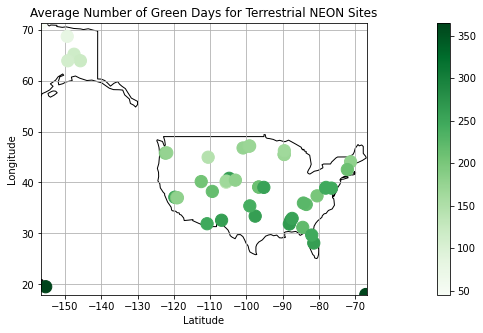

In [6]:
# Plot filtered data
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations and color by average number of green days
terrestrial_sites.plot(ax=ax, 
                       column="field_avg_number_of_green_days", 
                       cmap="Greens", 
                       legend=True, 
                       markersize=150, 
                       zorder=2)
# Set title
ax.set(xlabel="Latitude", 
       ylabel="Longitude", 
       title="Average Number of Green Days for Terrestrial NEON Sites")

# Use meta_bound_box.bounds to resrict plot to NEON site locations
plt.xlim(meta_bound_box.bounds[0], meta_bound_box.bounds[2])
plt.ylim(meta_bound_box.bounds[1], meta_bound_box.bounds[3])

# Add grid
plt.grid(zorder=0)

We will now filter our data further so that only NEON sites in the western part of the United States will remain in the dataframe. We will do this by creating a box and telling python to create a dataframe to only include NEON sites whose coordinates fall within the bounds of the box. Here we are defining the "west" as being to the left of the -100 latitudinal line.

In [7]:
# Filter your data with a bounding box to only include sites in the “west” using the cx method
# Create a box with box(minx, miny, maxx, maxy)
west_box = box(-130, 25, -100, 50)

# Filter
west_terr_sites = terrestrial_sites.cx[west_box.bounds[0]:west_box.bounds[2], 
                                       west_box.bounds[1]:west_box.bounds[3]]

We'll print the dataframe to confirm that only sites in the western part of the United States remain in the dataframe. We defined the west as being to the left of the -100 latitudinal line.

In [8]:
# Print filtered dataframe to confirm only western sites remain
west_terr_sites

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-122.33032 45.76244)
14,D10,CPER,Central Plains Experimental Range NEON,Core Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://www.ars.usda.gov/plains-area/fort-coll...,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Aridi...",Aridic Argiustolls,260.0,90,165,210,350,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-104.74559 40.81554)
29,D14,JORN,Jornada Experimental Range NEON,Gradient Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://jornada.nmsu.edu/,Yes,JORN encourages research activities that do no...,...,"Coarse, loamy, mixed, superactive, thermicc. T...",Typic Petrocalcids,260.0,80,185,245,340,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-106.84254 32.59069)
43,D13,MOAB,Moab NEON,Gradient Terrestrial,NaN,NaN,Bureau of Land Management,https://www.blm.gov/office/moab-field-office,Yes,Reseachers should coordinate with the site man...,...,"Coarse, loamy, mixed, superactive, mesic. Usti...",Ustic Haplocalcids,215.0,85,165,225,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-109.38827 38.24828)
44,D13,NIWO,Niwot Ridge NEON,Core Terrestrial,NaN,COMO,"US Forest Service, University of Colorado-Boulder",NaN,Yes,Reseachers should coordinate with the site man...,...,"Coarse, loamy, mixed, superactive. Typic Haplo...",Typic Haplocryolls,130.0,140,190,220,270,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-105.58237 40.05425)
45,D09,NOGP,Northern Great Plains Research Laboratory NEON,Gradient Terrestrial,NaN,NaN,USDA Agricultural Research Service,https://www.ars.usda.gov/plains-area/mandan-nd...,Yes,This site host welcomes and encourages additio...,...,"Fine, loamy, mixed, superactive, frigid. Typic...",Typic Argiustolls,175.0,115,170,200,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-100.91535 46.76972)
48,D15,ONAQ,Onaqui NEON,Core Terrestrial,NaN,NaN,Bureau of Land Management,https://www.blm.gov/office/salt-lake-field-office,Limited,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Xeric ...",Xeric Haplocalcids,205.0,75,130,170,280,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-112.45245 40.17760)
57,D10,RMNP,Rocky Mountains NEON,Gradient Terrestrial,NaN,NaN,Roosevelt National Forest,https://www.fs.usda.gov/arp,Yes,Researchers should coordinate directly with th...,...,"Loamy, skeletal, mixed, superactive. Ustic Hap...",Ustic Haplocryolls,165.0,120,180,210,285,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-105.54596 40.27590)
60,D17,SJER,San Joaquin Experimental Range NEON,Core Terrestrial,NaN,NaN,US Forest Service,https://www.fs.fed.us/psw/ef/san_joaquin/,Yes,Researchers should coordinate directly with th...,...,NaN,Psammentic Haploxerolls,250.0,270,65,95,155,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-119.73228 37.10878)
61,D17,SOAP,Soaproot Saddle NEON,Gradient Terrestrial,NaN,NaN,US Forest Service,https://www.fs.usda.gov/sierra/,Yes,Researchers should coordinate directly with th...,...,"Fine, loamy, mixed, semiactive, mesic. Ultic H...",Ultic Haploxeralfs,200.0,90,155,185,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-119.26219 37.03337)


The last filter we will do is to only include sites with evergreen trees present. We'll filter by the "field_dominant_nlcd_classes" column. After we filter, we'll take a look at the sites that remain by plotting.

In [9]:
# Filter the western NEON sites to only include sites with Evergreen trees present
evergreen_sites = west_terr_sites[(
    west_terr_sites["field_dominant_nlcd_classes"].str.contains("Evergreen Forest"))]

(25.0, 50.0)

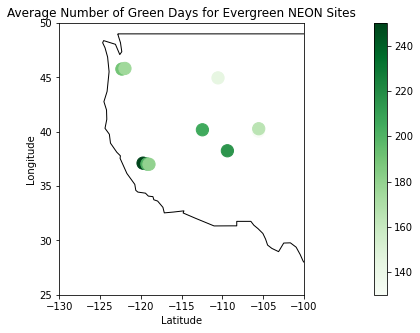

In [10]:
# Plot your Evergreen filter to confirm that your filter worked properly
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations and color by average number of green days
evergreen_sites.plot(ax=ax, 
                     column="field_avg_number_of_green_days", 
                     cmap="Greens", 
                     legend=True, 
                     markersize=150, 
                     zorder=2)

# Set title
ax.set(xlabel="Latitude", 
       ylabel="Longitude",
       title="Average Number of Green Days for Evergreen NEON Sites")

# Use west_box.bounds to resrict plot to NEON site locations to west
plt.xlim(west_box.bounds[0], west_box.bounds[2])
plt.ylim(west_box.bounds[1], west_box.bounds[3])

The last step is to create a list of the sites that remain after the final filtering step.

In [11]:
# Create a list of evergreen site ids (could be used in a loop for later processing)
evergreen_site_ids = evergreen_sites["field_site_id"].tolist()

# Check out list to make sure it worked
sorted(evergreen_site_ids)

['ABBY',
 'MOAB',
 'NIWO',
 'ONAQ',
 'RMNP',
 'SJER',
 'SOAP',
 'TEAK',
 'WREF',
 'YELL']

#### Writing a Function to Identify NEON Sites of Interest

Now we'll bring everything together that we did to create a function that will output the same list that's above.

In [12]:
# Create function that will do everything above and spit out a list of site ids
def get_site_ids(data_path, bounds, column1, column_info1, column2, column_info2):
    """Open NEON metadata file, turn it into a geopandas dataframe, and filter 
    the dataframe to only contain sites within a provided location.

    Parameters
    -----------
    data_path: string 
        A path to the csv to be opened.
    bounds: tuple
        A tuple with the order of minx, miny, maxx, maxy
    column1: pandas.Series
        A column within the dataframe that will be used to filter sites
    column_info1: string
        A string that specifies what information within column 1 you want to 
        use for filtering
    column2: pandas.Series
        A column within the dataframe that will be used to filter sites
    column_info2: string
        A string that specifies what information within column 2 you want to 
        use for filtering
     

    Returns
    -----------
    id_list : list
        A list of site ids

    """

    if os.path.basename(os.path.normpath(metadata_path)) == "NEON_Field_Site_Metadata_20220224.csv":

        # Open csv file
        metadata_df = pd.read_csv(data_path)
        
    else:
        print("Set your directory path to NEON_Field_Site_Metadata_20220224.csv before continuing.")

    # Convert pandas dataframe to a geopandas dataframe
    metadata_gpd = gpd.GeoDataFrame(metadata_df,
                                geometry=gpd.points_from_xy(metadata_df.field_longitude,
                                                            metadata_df.field_latitude))

    # Assign crs to metadata_gpd
    metadata_assigned_crs = metadata_gpd.set_crs(epsg=4326)
    

    # Filter your data with a box to only using the cx method
    filter_box = box(bounds[0], bounds[1], bounds[2], bounds[3])

    # Filter
    spatially_filtered_sites = metadata_assigned_crs.cx[filter_box.bounds[0]:filter_box.bounds[2], 
                                       filter_box.bounds[1]:filter_box.bounds[3]]

    if column1 in spatially_filtered_sites:
    
        # Filter by column1
        column1_gdf = spatially_filtered_sites[(
        spatially_filtered_sites[column1].str.contains(column_info1))]
    
    else:
        print("Oops, looks like the column you selected isn't in the dataframe.")
    
    if column2 in spatially_filtered_sites:
    
        # Filter by column2
        column2_gdf = column1_gdf[(
        column1_gdf[column2].str.contains(column_info2))]
    
    else:
        print("Oops, looks like the column you selected isn't in the dataframe.")
    
    # Create a list of site ids (could be used in a loop for later processing)
    site_ids = column2_gdf["field_site_id"].tolist()

    return site_ids

This function is included in the macrosystem_module that is imported in the first code cell. I'll use it in the cell below to test the function above.

In [13]:
# Test function
ids = macmo.get_site_ids(metadata_path, (-130, 25, -100, 50), 
                   "field_site_type", 
                   "Terrestrial", 
                   "field_dominant_nlcd_classes", 
                   "Evergreen Forest")
ids

['ABBY',
 'MOAB',
 'NIWO',
 'ONAQ',
 'RMNP',
 'SJER',
 'SOAP',
 'TEAK',
 'WREF',
 'YELL']

#### Accessing NEON's API

For our next step, we'll explore NEON's API, see the datasets that are available, and select the one that ultimately met our requirements. We will be exploring only the data associated with the Niwot Ridge site. We were looking for a dataset that had spectral data and is in a map or tiled format, so we were looking for datasets that were either in hdf5 or tif formats. We identified approximately 12 datasets that matched our criteria. Of those 12, we needed to find the one that had spectral data for 10 bands that will be [captured by a sensor attached to a drone](https://uavprime.com/wp-content/uploads/2021/04/RedEdge-MX-Dual-Camera-Whitepaper.pdf) that will be deployed over NEON sites. We also needed to determine whether spectral data within a dataset captured bands in their entirety or in small chunks (tif vs. hdf5).

In [14]:
# Server URL
server = "http://data.neonscience.org/api/v0/"

# Niwot Ridge site code
sitecode = "NIWO"

# Make request using the sites/ endpoint
site_request = requests.get(server+"sites/"+sitecode)

# Convert to json object
site_json = site_request.json()

In [15]:
# Use the "keys" method to view the component of the uppermost json dictionary
site_json.keys()

dict_keys(['data'])

In [16]:
# See what is stored in "data"
site_json["data"].keys()

dict_keys(['siteCode', 'siteName', 'siteDescription', 'siteType', 'siteLatitude', 'siteLongitude', 'stateCode', 'stateName', 'domainCode', 'domainName', 'deimsId', 'releases', 'dataProducts'])

In [17]:
# Print all product codes and titles in dataProducts
for product in site_json["data"]["dataProducts"]:
    print(product["dataProductCode"],product["dataProductTitle"])

DP1.00001.001 2D wind speed and direction
DP1.00002.001 Single aspirated air temperature
DP1.00003.001 Triple aspirated air temperature
DP1.00004.001 Barometric pressure
DP1.00005.001 IR biological temperature
DP1.00006.001 Precipitation
DP1.00013.001 Wet deposition chemical analysis
DP1.00014.001 Shortwave radiation (direct and diffuse pyranometer)
DP1.00017.001 Dust and particulate size distribution
DP1.00022.001 Shortwave radiation (primary pyranometer)
DP1.00023.001 Shortwave and longwave radiation (net radiometer)
DP1.00024.001 Photosynthetically active radiation (PAR)
DP1.00033.001 Phenology images
DP1.00038.001 Stable isotopes in precipitation
DP1.00040.001 Soil heat flux plate
DP1.00041.001 Soil temperature
DP1.00042.001 Snow depth and understory phenology images
DP1.00043.001 Spectral sun photometer - calibrated sky radiances
DP1.00066.001 Photosynthetically active radiation (quantum line)
DP1.00094.001 Soil water content and water salinity
DP1.00095.001 Soil CO2 concentration

The output above is all of the dataproducts associated with Niwot Ridge. As you can see, not all of these will contain spectral data. We determined that DP3.30006.001 Spectrometer orthorectified surface directional reflectance - mosaic had the data that we want in the format that we want. Now, we'll explore it a bit.

#### Download the Selected Dataset

In [18]:
# Assign product code of interest to a variable
mosaic_dataset_code = "DP3.30006.001"

# Make Request for data collected in August of 2020
h5_request = requests.get(server+"data"+"/"+mosaic_dataset_code+"/"+sitecode+"/"+"2020-08")

# Convert to json object
h5_json = h5_request.json()

In [19]:
# Look at the uppermost layer of dictionary
print(h5_json.keys())

dict_keys(['data'])


In [20]:
# Look at the data keys
print(h5_json["data"].keys())

dict_keys(['productCode', 'siteCode', 'month', 'release', 'packages', 'files'])


In [21]:
# Look at what is contained in "files"
print(h5_json["data"]["files"][0].keys())

dict_keys(['name', 'size', 'md5', 'crc32', 'crc32c', 'url'])


In [22]:
# Get the url for the first h5 file
for file in h5_json["data"]["files"]:
    if((file["name"] == "NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")):
        print(file["url"])

https://storage.googleapis.com/neon-aop-products/2020/FullSite/D13/2020_NIWO_4/L3/Spectrometer/Reflectance/NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5


In [23]:
# Download the data
et.data.get_data(url="https://storage.googleapis.com/neon-aop-products/2020/FullSite/D13/2020_NIWO_4/L3/Spectrometer/Reflectance/NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")

'C:\\Users\\Rachel\\earth-analytics\\data\\earthpy-downloads\\NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5'

#### Explore the Dataset

Now that the hdf5 file has been saved to your earthpy-downloads folder in your earth-analytics/data directory, we can explore the data and visualize it. Let's start by plotting the waveform of the data. To do this, we need the reflectance and wavelength data in the file.

In [24]:
# Create path to hdf5 file
hdf5_path = os.path.join("data", "earthpy-downloads", "NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")

Include function to open hdf5 files

In [25]:
def aop_h5refl2array(refl_filename):
    """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
    """
    
    # Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    # Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    # Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]["Reflectance"]
    reflData = refl["Reflectance_Data"]
    reflRaw = refl["Reflectance_Data"][:]
    
    # Create dictionary containing relevant metadata information
    metadata = {}
    metadata["wavelength"] = refl["Metadata"]["Spectral_Data"]["Wavelength"]

    # Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    
    # Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata["data ignore value"] in reflRaw:
        print("% No Data: ",np.round(np.count_nonzero(reflClean==metadata["data ignore value"])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata["data ignore value"])
        reflClean[nodata_ind]=np.nan 
    
    # Apply scale factor
    reflArray = reflClean/metadata["reflectance scale factor"]
    
    # Extract spatial extent from attributes
    metadata["spatial extent"] = reflData.attrs["Spatial_Extent_meters"]
    
    # Extract bad band windows
    metadata["bad band window1"] = (refl.attrs["Band_Window_1_Nanometers"])
    metadata["bad band window2"] = (refl.attrs["Band_Window_2_Nanometers"])
    
    # Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl["Metadata"]["Coordinate_System"]["Map_Info"]
    
    hdf5_file.close        
    
    return reflArray, metadata

In [26]:
# Read in file and save reflectance data to a variable
niwo_refl, niwo_refl_md = aop_h5refl2array(hdf5_path)

In [27]:
# Loop through reflectance array to calculate mean reflectance for each band
# Create empty list
reflectance = []
for band in np.arange(niwo_refl.shape[2]):
        refl_band = niwo_refl[:,:,band]
        refl_mean = refl_band.mean()
        reflectance.append(refl_mean)

In [28]:
# Assign wavelength data to a variable
wavelengths = niwo_refl_md["wavelength"]

In [29]:
# Print min and max wavelength values
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

min wavelength: 381.667 nm
max wavelength: 2510.0774 nm


In [30]:
# Create pandas dataframe for plotting
refl_df = pd.DataFrame()
refl_df["wavelength"] = wavelengths
refl_df["reflectance"] = reflectance
refl_df

,wavelength,reflectance
0,381.666992,0.034503
1,386.674988,0.022135
2,391.683014,0.019015
3,396.691101,0.019928
4,401.699097,0.018717
...,...,...
421,2490.045410,0.015688
422,2495.053223,0.019516
423,2500.061279,0.020172
424,2505.069336,0.017080


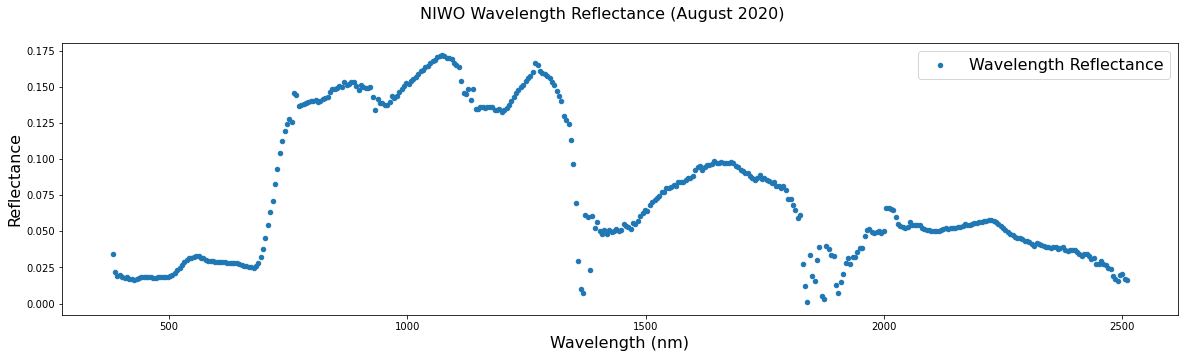

In [31]:
# Define figure space
fig, ax = plt.subplots(figsize=(20, 5))

# Plot wavelength
refl_df.plot(ax=ax, 
             x="wavelength",
             y="reflectance",
             kind="scatter", 
             label="Wavelength Reflectance",
             legend=True)

# Set title
fig.suptitle("NIWO Wavelength Reflectance (August 2020)", fontsize=16)

# Set x and y axis labels
plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Reflectance", fontsize=16)

# Add legend
ax.legend(prop={'size': 16})

fig.savefig("niwo_waveform.png")

Now, we'll plot just one band that represents the red

In [32]:
# Extract red band
red_band = niwo_refl[:,:,57]

# What does the data look like?
red_band

array([[0.0017, 0.    , 0.0017, ..., 0.0251, 0.0362, 0.0224],
       [0.0005, 0.0044, 0.0051, ..., 0.0198, 0.0145, 0.0251],
       [0.    , 0.0032, 0.0089, ..., 0.0245, 0.0212, 0.0205],
       ...,
       [0.0131, 0.0099, 0.0132, ..., 0.038 , 0.0235, 0.0141],
       [0.0144, 0.0183, 0.0178, ..., 0.0033, 0.0022, 0.0194],
       [0.0215, 0.016 , 0.0156, ..., 0.0009, 0.0016, 0.0215]])

We'll now look at the range and distribution of reflectance values by making a histogram.

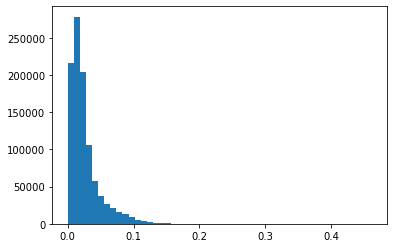

In [33]:
plt.hist(red_band[~np.isnan(red_band)],50);

We can see that most of the reflectance values are < 0.2. In order to show more contrast in the image, we can adjust the values that are plotted by telling the function to only plot data values that are from to 0-0.2 by using the vmin and vmax parameters.

Text(0.5, 1.0, 'NIWOT Level 3 Orthorectified Mosaic Dataset \n Red Band Reflectance (August 2020)')

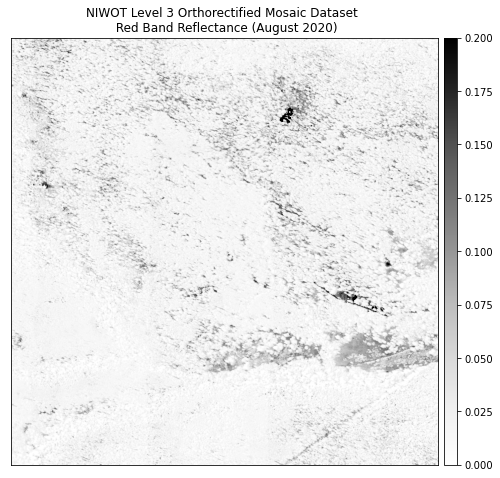

In [34]:
# Define figure space
fig, ax = plt.subplots(figsize=(8, 8))

# Subplot 1: classified dNBR using Landsat data
ep.plot_bands(red_band,
              cmap="Greys",
              scale=False, 
              vmin=0, 
              vmax=0.2,
              ax=ax)
ax.set_title("NIWOT Level 3 Orthorectified Mosaic Dataset \n Red Band Reflectance (August 2020)")

### Current Findings and Conclusions

In conclusion we have identified the dataset that we will be using for the rest of project. The next step is to create boxes in python that encompass the wavelengths captured by the drone sensor and overlay these on the waveform. There will be a total of ten boxes. Using these boxes we will filter the 426 bands contained in the hdf5 file to extract only the bands whose wavelengths are captured by the drone sensor. We will then move forward with these bands to begin calculating differences between reflectance values between sites to determine the spectral variation between sites.

#### Data Citations

All data used in this notebook was made available by the National Ecological Observatory Network (NEON).